# 7. Ordinary differential equations III

In the previous lecture, we discussed some alternatives for one of the cases in which Runge-Kutta methods are inefficient: when low tolerance (high accuracy) is required. This chapter deals with another case Runge-Kutta (and other, polynomial-based) methods cannot handle: when the solution oscillates rapidly.

## 7.1 The problem and why some methods fail 

We'll solve the initial value problem (IVP)

```{math}
:label: osc-ivp
u''(t) + \omega^2(t)u(t) &= 0, \quad t \in [a,b], \\
u(a) &= u_0, \\
u'(a) &= u'_0.

```

Physically, $u$ describes how the position of a simple harmonic oscillator changes with time. The oscillator moves with a time-dependent frequency $\omega$. If $\omega$ is real, then the solution is oscillatory, if it has an imaginary component, then it decays exponentially (while potentially oscillating inside the evanescent envelope). The larger $\omega$, the faster the oscillations (the shorter the period and wavelength).

```{admonition} Question
When approximating an oscillatory function with characteristic frequency $\omega$, what is the complexity of a polynomial-based (e.g. Runge-Kutta) algorithm? I.e., if its runtime is $\mathcal{O}(f(\omega))$, what is the function $f$?
```

Polynomial-based methods (meaning: methods which fit some sort of polynomial to approximate the solution) have a complexity of $\mathcal{O}(\omega)$ when dealing with oscillatory problems. This is due to their discretization length (e.g. stepsize, or node-spacing) having to decrease proportionally to the wavelength, which is $\propto \tfrac{1}{\omega}$, hence their runtime being $\propto \omega$. This unfortunately gets too long at large values of $\omega$. Let's check this expected scaling by solving 

In [47]:
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
import time
%matplotlib inline

\begin{align}
u'' + \omega_0^2u &= 0 \quad t \in [-1, 1]\\
u(-1) &= 1, \\
u'(-1) &= 0.
\end{align}

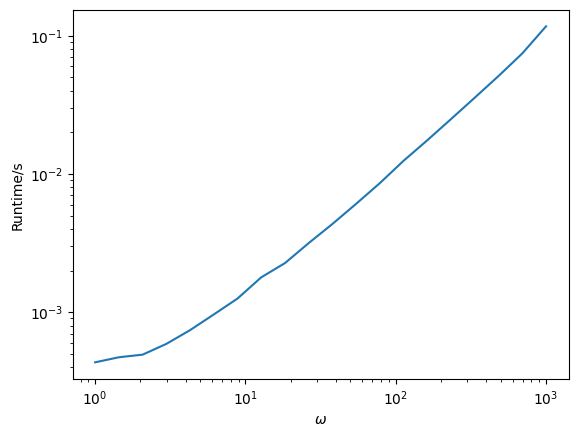

In [57]:
# Scipy's default Runge-Kutta solver

def f_ivp(t, u):
    """ The right-hand-side in u' = f(t, u). """
    du = np.zeros(2)
    du[0] = u[1]
    du[1] = - om**2*u[0]
    return du

u0 = np.array([1, 0])
tspan = (-1, 1)

ws = np.logspace(0, 3, 20)
times = np.zeros_like(ws)

for i, w in enumerate(ws):
    om = w
    N = int(10000/om)
    t1 = time.time()
    for j in range(N):
        solution = si.solve_ivp(f_ivp, tspan, u0)
    t2 = time.time()
    times[i] = (t2 - t1)/N
    
plt.figure()
plt.loglog(ws, times)
plt.xlabel("$\omega$")
plt.ylabel("Runtime/s")
plt.show()

As expected, the runtime of `scipy`'s default Runge-Kutta solver scales as $\mathcal{O}(\omega)$.

```{admonition} Question
By the way, notice how when I time the algorithm, I run it many times in a loop, then take the average of the overall runtime? Why is this necessary?
```

Aside: when measuring the performance of a piece of code, make sure to run it multiple times, _especially_ if the runtime is expected to be short. Otherwise this happens (here, I omitted the loop):

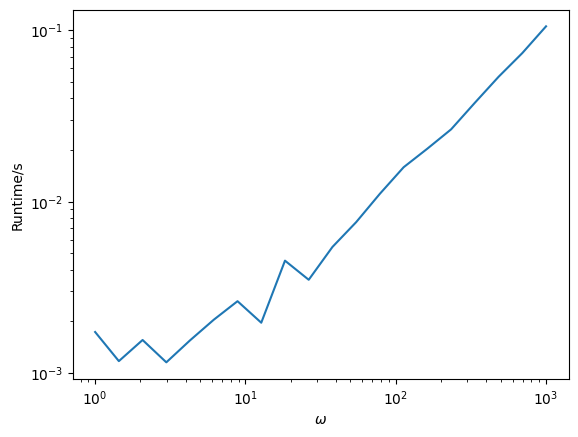

In [58]:
ws = np.logspace(0, 3, 20)
times = np.zeros_like(ws)

for i, w in enumerate(ws):
    om = w
    t1 = time.time()
    solution = si.solve_ivp(f_ivp, tspan, u0)
    t2 = time.time()
    times[i] = (t2 - t1)
    
plt.figure()
plt.loglog(ws, times)
plt.xlabel("$\omega$")
plt.ylabel("Runtime/s")
plt.show()

Something weird is going on at small values of $\omega$. The runtime of `time.time()` itself and other things (e.g. other things running inside a notebook, initialization, etc.) will add to the overall runtime, and may be significant relative to that of the code you want to measure. It's important to reduce this noise by averaging to get an accurate measurement.

The core reason why methods like RK struggle is that you need a polynomial of at least degree-$n$ to approximate a function that crosses zero $n$ times, and oscillatory functions cross zero many times. This hints at the solution, however: we need something other than polynomials to approximate the solution with. How about something oscillatory, e.g. trigonometric functions? 

But first, let's review what components one needs for constructing a "bespoke" numerical solver.

## 7.2 Components of a solver

Solvers for IVPs generally march along the numerical solution, starting from some known initial conditions and adapting their behavior to that of the solution (e.g. their stepsize) to keep their estimate of the error below a user-specified **tolerance** $\varepsilon$. From here onwards, I'll use the notation $u(t)$ to mean the _exact_ solution to the IVP, and $\tilde{u}_i$ for $i = 0, 1, \ldots$ will mean values of the numerical solution at the timesteps $t_i$, with $t_0 = a$. 
Solvers will need the following three components to work:

1. A numerical "forecaster" function $\Phi_h$ that takes the numerical solution at the start of a timestep and gives back the solution at the end of a step. 

$$ \tilde{u}_{i+1} = \Phi_h(\tilde{u}_i, \tilde{u}_{i-1}, \ldots ; t_i, t_{i-1}, \ldots ; f), $$

where $f$ is the right-hand-side of the ODE if written in the form $u' = f(t, u)$. 

2. An estimate of the **local error** of the method is needed, which is the amount of error the method accumulates in a single timestep. It is defined as

$$ \Delta_i := u(t_{i+1}) - \Phi_h(u(t_i), \ldots; t_i, \ldots; f). $$

Note how the inputs of $\Phi_h$ in this definition are the values of the exact solution (we pretend that the solver has access to the exact answer at the start of the timestep, so the only source of error will be the current timestep). The "unit" local error is $\delta_i := \frac{\Delta_i}{h}$.

3. This local error estimate is used to define a **controller**, which does two things: it accepts or rejects proposals for $\tilde{u}_{i}$ depending on the local error estimate $\Delta_{i}$, and proposes the next stepsize, $h_{i+1}$ (or a new $h_i$ if the step was rejected). This adaptive way of updating the stepsize is crucial in modern, efficient solvers, and it requires information about the dependence of the local error on the stepsize, $\Delta(h)$.

We'll now review each of these components that make up a specialized solver for IVPs of the form {eq}`osc-ivp`.

## 7.3 Riccati defect correction

The idea behind the method I'll introduce, named Riccati defect correction, is that we want to find an underlying quantity related to the solution $u(t)$ that is well-approximated by polynomials, e.g. something monotonically increasing. 

```{admonition} Question
Can you think of such a quantity?
```

An idea is to consider time-stepping in terms of the _phase_ of oscillations, which is expected to monotonically increase. We'll actually consider the derivative of the phase.

```{admonition} Question
What variable substitution will get us to the differential equation obeyed by this phase-derivative?
```

Since the solution of {eq}`osc-ivp` is expected to be oscillatory, it makes sense to make the substitution

$$ u = e^{\int^t x(\sigma) \mathrm{d}\sigma}, $$

which gives us the **Riccati equation**

```{math}
:label: riccati
x' + x^2 + \omega^2 = 0.
```

We might hope to brute-force numerically solve this equation, but that's a bad idea for multiple reasons:
- it's first-order _nonlinear_ ODE, so we'd have to worry about the existence and uniqueness of the solution,
- it's prone to instabilities that have twice the oscillation frequency as the original solution.

This latter issue can be demonstrated with a simple example: consider the "zeroth-order" case of constant $\omega(t) = \omega_0$. In this case the Riccati equation possesses an analytic solution

$$ x(t) = \omega_0\tan(\alpha - \omega_0t), $$

where $\alpha \in \mathbb{C}$ is a complex parameter corresponding to the initial conditions. This solution is in general periodic with a period $\propto \tfrac{1}{2\omega_0}$ (think about the period of the $\tan$ function vs. $\cos$). Its real part controls the phase of oscillations, its imaginary part controls their amplitude. It's only in the limit of $\mathrm{Im}(\alpha) \to \infty$ that we get a nonoscillatory solution for $x$, $x(t) = \pm i\omega(t)$, so a naive numerical approach is guaranteed to suffer from oscillatory instabilities. The code snippet below plots the solution for $x$ as we change $\mathrm{Im}(\alpha)$; observe how the oscillations die down as it is increased and note the symmetric-log scaling of the $y$-axis (which turns to linear at $|y| < 10^{-6}$).

In [45]:
from matplotlib.legend_handler import HandlerTuple

class HandlerTupleVertical(HandlerTuple):
    def __init__(self, **kwargs):
        HandlerTuple.__init__(self, **kwargs)

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        numlines = len(orig_handle)
        handler_map = legend.get_legend_handler_map()
        height_y = (height / numlines)
        leglines = []
        for i, handle in enumerate(orig_handle):
            handler = legend.get_legend_handler(handler_map, handle)
            legline = handler.create_artists(legend, handle, xdescent, (2*i + 1)*height_y, width, 2*height, fontsize, trans) 
            leglines.extend(legline)
        return leglines

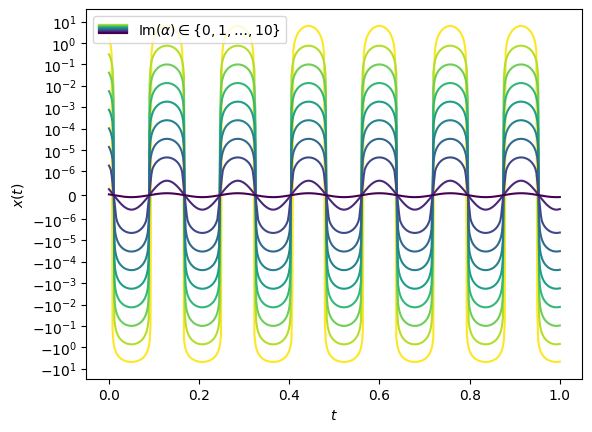

In [54]:
n = 9
imalphs = np.linspace(1, n+1, n+1)
alphs = 1.0 + imalphs*1j
om0 = 20
ts = np.linspace(0, 1, 500)

colors = plt.cm.viridis(np.linspace(1, 0, n+1))

fig, ax = plt.subplots(1, 1)
ls = ()
for i, a in enumerate(alphs):
    us = (om0*np.tan(a - om0*ts)) - 1j*om0  
    l, = ax.plot(ts, us.imag, color = colors[i])
    ls += (l,)
plt.yscale('symlog', linthresh = 1e-6)    
plt.xlabel("$t$")
plt.ylabel("$x(t)$")
leg = ax.legend([ls], ['$\mathrm{Im}(\\alpha) \in \{ 0, 1, \ldots, 10\}$'],
        handler_map = {tuple: HandlerTupleVertical()})    
plt.show()

We'll use a different approach: a **defect correction** scheme. We'll construct a series of increasingly refined approximations to the true $x$: $x_0(t), x_1(t), \ldots, x_j(t)$. Each iteration, we add a small correction term $\delta(t)$ to get to the next. We'll start from a nonoscillatory initial guess $x_0(t)$, and make sure that $\delta(t)$ is also nonoscillatory, thereby building a guaranteed nonoscillatory approximation to $x(t)$. 

```{admonition} Question
What's a good initial guess $x_0(t)$? Hint: think back to the constant-$\omega$ solution.
```

Inspired by the constant-$\omega$ solution, a good choice for $x_0(t)$ is

$$x_0(t) = \pm i\omega(t). $$

Now we measure the goodness of each estimate by how well they satisfy the Riccati equation (that $x$ is supposed to obey) by defining the **residual**,

$$ R[x_j](t) := x_j' + x_j^2 + \omega^2, $$

which is a functional (a function of a function). Assuming now that we have iterated $j$ times and found our $j$th estimate $x_j(t)$, we want to find the _small_, _nonoscillatory_ correction term $\delta(t)$ (note that this is a function) that minimizes the residual of the next iteration,

$$ R[x_{j+1}](t) = R[x_j + \delta](t) = x_j' + \delta' + x_j^2 + 2x_j \delta + delta^2 + \omega^2 = 0. $$

Identifying the $R[x_j]$ term on the right-hand side gives

$$ 0 = R[x_j] + \delta' + 2x_j \delta + \delta^2. $$

This is a first order, nonlinear ODE for $\delta$, which unfortunately suffers from the same instabilities as the Riccati equation, so solving it numerically would be extraordinarily expensive. So instead, we inspect the terms to see if there are any that can be safely neglected. For this, we need to define what nonoscillatory means: if $x$ is nonoscillatory, its derivative must be the same order of magnitude (with respect to $\omega$) as $x$ itself, i.e. $x' = \mathcal{O}(x)$. We assume that $\omega$ and $\delta$ are nonoscillatory as well, and that $\delta$ is small. This means we can drop two terms:
- the $\delta^2$ term is small compared to the rest due to the extra factor of $\delta$ (this is called "linearization" of the ODE),
- the $\delta'$ term is a factor $\mathcal{O}(\omega)$ smaller than the rest. To see this, try substituting $x_0$ for $x_j$, and see how large the terms are: the first one is $\propto \omega' = \mathcal{O}(\omega') = \mathcal{O}(\omega)$, the third one is $\mathcal{O}(\omega)\mathcal{O}(\delta)$, whereas the second one is just $\mathcal{O}(\delta)$. 

We are left with $ 0 = R[x_j] + 2x_j\delta,$ solving which gives our defect correction iteration

$$ x_{j+1} = x_j - \frac{R[x_j]}{2x_j}. $$

In the next section we will see that the series $x_0, x_1, x_2, \ldots$ is not actually convergent, it's an **asymptotic** series. Asymptoticity means that the series only approaches the true solution in some limit, in our case it will be $\omega \to \infty$. In general, the residual will only decrease up to a certain number of iterations ($\mathcal{O}(\omega)$ of them), after which it will start blowing up. This instability is brought upon by the repeated differentiation hiding in the $R[x]$. 

To summarize, the forecasting step of the numerical method based on this defect correction scheme will look like this:
1. Starting from $x_0 = \pm i\omega$, we iterate over the $x_j$ until the residual $R[x_j]$ drops below a user-specified tolerance $\varepsilon$.
2. Then we transform back from the phase-derivative $x$ to $u$ via $u = e^{\int^t x(\sigma) \mathrm{d}\sigma}$. Depending on whether we started from $x_0 = +i\omega$ or $-i\omega$, we get two phase-derivatives $x_{\pm}$ and therefore linearly independent approximate solutions of {eq}`osc-ivp`, $u_+$ and $u_-$.
3. We find the linear combination of $u_{\pm}$, $Au_+ + Bu_-$, that satisfies the initial conditions of the IVP by solving the linear system
$$  \begin{bmatrix} u_+ & u_- \\ x_+u_+ & x_-u_-\end{bmatrix}\begin{bmatrix} A \\ B \end{bmatrix} = \begin{bmatrix} u_0 \\ u'_0 \end{bmatrix}. $$

## 7.4 Local error of the Riccati defect correction

The second component of this numerical method is its local error estimate, for which we'll use the residual $R[x]$. A quick check of the residual of $u$ reveals that this is a measure of the relative residual of $u$,

$$R[u](t) = u'' + \omega^2 u = (x' + x^2 + \omega^2)u = R[x]u,$$

therefore $R[x] = R[u]/u$. We need to find how this quantity depends on the width of the interval we apply the defect correction to (the stepsize). Unlike the local truncation error of Runge-Kutta methods, this is not a simple $\Delta = \mathcal{O}(h^{p+1})$-type relationship.

To get an idea of how the residual decreases during iterations of the Riccati defect correction, let's inspect the first couple terms in the series and their residual:

\begin{align}
x_0 &= i\omega, \quad  &&R[x_0] = i\omega' = \mathcal{O}(\omega), \\
x_1 &= i\omega - \frac{\omega'}{2\omega}, \quad &&R[x_1] = \frac{3(\omega')^2}{4\omega^2} - \frac{\omega''}{2\omega} = \mathcal{O}(1).
\end{align}

(In the above, I used the non-oscillatory assumption $\omega'' = \mathcal{O}(\omega') = \mathcal{O}(\omega)$.) This signals that for at least the first few iterations, we might get an $\mathcal{O}(\omega)$ reduction in the residual, making this defect correction very efficient for approximating highly oscillatory (large-$\omega$) functions! Thanks to the simple recursion relation involved, it's possible to analyze the error in the defect correction more rigorously and prove the following theorem.

```{admonition}
:class: warning
This is probably the most complex theorem/proof in the course. But don't be discouraged, all components are things that you will have seen and can definitely follow.
```

```{admonition} Theorem
:class: hint
Fix $t \in \mathbb{R}$. Let $\omega$ be analytic in the closed disc $B_\rho(t) := \{ z \in \mathbb{C}: |z - t| \leq \rho\}$ for some $\rho > 0$ with bounds

\begin{align}
\eta_1 \leq &|\omega(z)| \leq \eta_2, \\
&|\omega'(z)| \leq \eta_3 \leq \frac{\eta_1^2}{18}.
\end{align}

Further let an integer $k \geq 0$ be small enough so that 

$$ r:= \frac{1}{2\tilde{\eta}_1\rho}\left( 1 + \frac{\tilde{\eta}_2}{\tilde{\eta}_1}\right) k + \frac{\eta_3}{4\tilde{\eta}^2_1} \leq \frac{4}{5},$$

where $\tilde{\eta}_1 := \eta_1 - \frac{3\eta_3}{\eta_1}$, $\tilde{\eta}_2 := \eta_2 + \frac{3\eta_3}{\eta_1}. $

Then after any number $j \leq k$ of iterations, the residual is bounded at the point $t$ by 

$$ |R_j(t)| \leq \eta_3 r^j. $$

```

```{admonition} Question
Think carefully about the assumptions and the statement of this theorem, and try to put into your own words
- under what the conditions will the rate $r$ be small,
- what the bounds on $\omega$ and its derivative have to be in order for $r$ to be small if $\rho$ is small or $k$ is large, and when $\rho$ is large and $k$ is small,
- what do these all mean for the rate of the residual reduction? What properties does $\omega$ need to have in order for the error $R_j$ to drop quickly?
```



In [55]:
def chebD(n):
    """
    Computes the (n+1)x(n+1) spectral differentiation matrix\
    using Chebyshev roots according to Ch 6 of Trefethen's\
    "Spectral methods in MATLAB". Returns D and nodes on [-1, 1].
    Note that they are ordered backwards, i.e. 1 to -1!
    """
    if n == 0:
        x = 1; D = 0; w = 0
    else:
        a = np.linspace(0.0, np.pi, n+1)
        x = np.cos(a)
        b = np.ones_like(x)
        b[0] = 2; b[-1] = 2
        d = np.ones_like(b)
        d[1::2] = -1
        c = b*d
        X = np.outer(x, np.ones(n+1))
        dX = X - X.T
        D = np.outer(c, 1/c) / (dX + np.identity(n+1))
        D = D - np.diag(D.sum(axis=1))
    return D, x

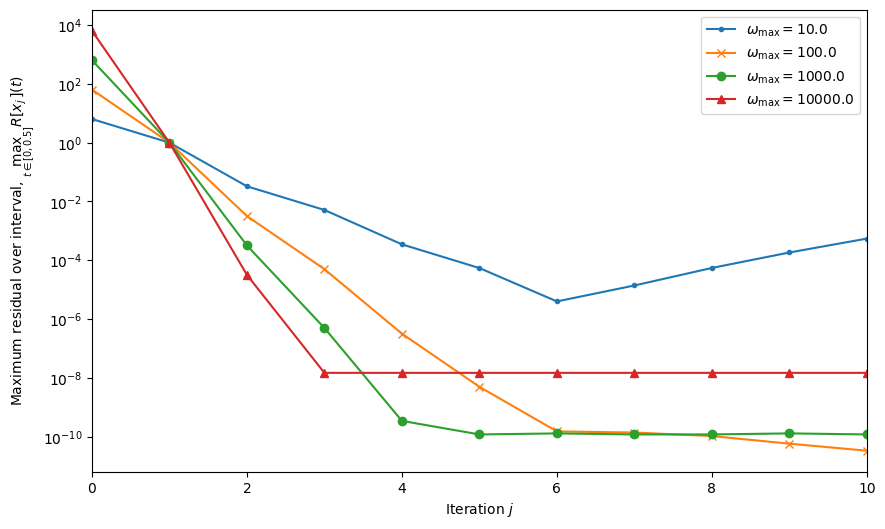

In [56]:
def ricc_defect_corr(n, w, t0, h, k = 10):
    """
    Performs k+1 steps of Riccati defect correction and returns the residuals of x.
    """
    errs = np.zeros(k+1)
    D, t = chebD(n)
    tscaled = (t + 1)/2*h + t0 
    ws = w(tscaled)
    x = 1j*ws
    R = lambda x: 2/h*(D @ x) + x**2 + ws**2
    Rx = 1j*2*(1/h*(D @ ws))
    errs[0] = max(np.abs(Rx))
    o = 0 # Keep track of number of terms
    while o < k:
        o += 1
        x = x - Rx/(2*x)
        Rx = R(x)
        errs[o] = max(np.abs(Rx))
    return errs


n = 16
k = 10
symbols= ['.', 'x', 'o', '^']

plt.figure(figsize = (10, 6))
for i, m in enumerate(np.logspace(1, 4, 4)):
    w = lambda t: np.sqrt(m**2 - 1)/(1 + t**2)
    errs = ricc_defect_corr(n, w, 0, 0.5, k = k)
    plt.semilogy(range(k+1), errs, marker = symbols[i], label = '$\omega_{\mathrm{max}} =' + '{}'.format(m) + '$')
plt.xlabel("Iteration $j$")
plt.ylabel("Maximum residual over interval, $\max_{t \in [0, 0.5]}R[x_j](t)$")
plt.xlim((0, 10))
plt.legend()
plt.show()